# FarTrend Customer Segmentation and Recommendation System


## Background Story  

In the ever-evolving landscape of e-commerce, understanding customer behavior has become a cornerstone of strategic marketing. An emerging e-commerce giant, "FarTrend," has experienced rapid growth by offering a wide range of products from fashion to electronics, catering to over 3400 customers across diverse demographics. Despite their success, FarTrend faces challenges in personalizing marketing efforts and predicting future purchasing behavior, crucial for sustaining growth and enhancing customer satisfaction.

## The Challenge

FarTrend's extensive customer database reveals purchasing patterns over the past year but lacks actionable insights to anticipate the needs of new customers. Traditional marketing strategies have yielded moderate success; however, the leadership team believes that a more data-driven approach could unlock exponential growth.

You are working on the marketing intelligence team! Your goal is to develop a  machine learning model that segments FarTrend's customer base and predicts future purchases of new customers within their first year. This model aims to transform FarTrend approach to customer engagement by delivering personalized marketing campaigns and tailored product recommendations.

## Data Description

The IT extracted a dataframe with the main transaction performed by the customers. 

##### Variables
InvoiceNo: Invoice number. A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. A 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name.

Quantity: The quantities of each product (item) per transaction. 

InvoiceDate: The day and time when each transaction was generated.

UnitPrice: Product price per unit.

CustomerID: Unique customer number. 

Country: The name of the country where each customer resides.

## Part 1: Data Quality and Customer Understanding 

#### P1.1 Exploratory data analysis of the data.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from tabulate import tabulate
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GroupShuffleSplit

In [3]:
#Loading the data
df =  pd.read_excel('../data/FarTrend_eRetail.xlsx')

In [4]:
#Dataset overview
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### Dataset Overview
- **Entries**: 541,909
- **Columns**: 8

Columns Summary:
- **InvoiceNo**: Object type, contains invoice numbers. Represents multiple items per transaction.
- **StockCode**: Object type, product code for each item.
- **Description**: Object type, product descriptions. Some missing values (540,455 non-null).
- **Quantity**: Integer, quantity of products per transaction.
- **InvoiceDate**: Datetime, date and time of transaction.
- **UnitPrice**: Float, unit price of products.
- **CustomerID**: Float, customer ID for transactions. Significant missing values (406,829 non-null).
- **Country**: Object type, country of transaction.

Preliminary Inferences:
- Missing values in **Description** and **CustomerID** need attention.
- **InvoiceDate** in datetime format aids time series analysis.
- Multiple transactions possible per customer.

Next Steps:
- Address missing and potentially erroneous data.
- Preprocessing for data cleaning and feature creation.

In [7]:
#SUMMARY STATISTICS
# Summary statistics for numerical variables
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


The extreme values in Quantity and UnitPrice suggest the presence of significant outliers or data entry errors that need to be addressed. For example, negative values in UnitPrice could indicate refunds or cancellations, and extreme values in both Quantity and UnitPrice could distort analyses.
The difference in count between the total transactions and those with a non-null CustomerID highlights missing customer information in a substantial number of transactions, which could impact customer-specific analyses.

In [8]:
#categorical variables
df.describe(include='object')

,InvoiceNo,StockCode,Description,Country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478


**Data Insights**

Quantity
- **Average**: 9.55 per transaction.
- **Range**: -80995 to 80995. Negative values indicate returns/cancellations.
- **Standard Deviation**: Large, indicating significant spread and presence of outliers.

UnitPrice
- **Average**: 4.61.
- **Range**: -11062.06 to 38970. Negative values suggest errors.
- **Outliers**: Indicated by a large gap between the 75th percentile and maximum values.

CustomerID
- **Non-null Entries**: 406,829. Missing values present.
- **ID Range**: 12346 to 18287.

InvoiceNo
- **Unique Invoices**: 25,900.
- **Most Frequent**: Invoice 573585 appears 1,114 times.

StockCode
- **Unique Codes**: 4,070.
- **Most Frequent**: Code 85123A appears 2,313 times.

Description
- **Unique Descriptions**: 4,223.
- **Most Frequent**: "WHITE HANGING HEART T-LIGHT HOLDER" appears 2,369 times.
- **Missing Values**: Present and need attention.

Country
- **Unique Countries**: 38.
- **Dominance**: 91.4% of transactions are from the United Kingdom.


Product Popularity: The 'WHITE HANGING HEART T-LIGHT HOLDER' is identified as the most popular product. This insight could be valuable for inventory and marketing strategies.
Customer Base: The vast majority of transactions are from the United Kingdom, highlighting the importance of this market to FarTrend. However, the presence of 37 other countries in the dataset indicates a significant international customer base that could be explored for expansion or targeted marketing.
Data Integrity: The slight discrepancy between the number of unique stock codes and descriptions suggests some data cleaning may be needed to standardize product information.

In [9]:
#DATA CLEANING
#Checking for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
#calculating the percentage of missing values
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

missing_percentage

Description     0.268311
CustomerID     24.926694
dtype: float64

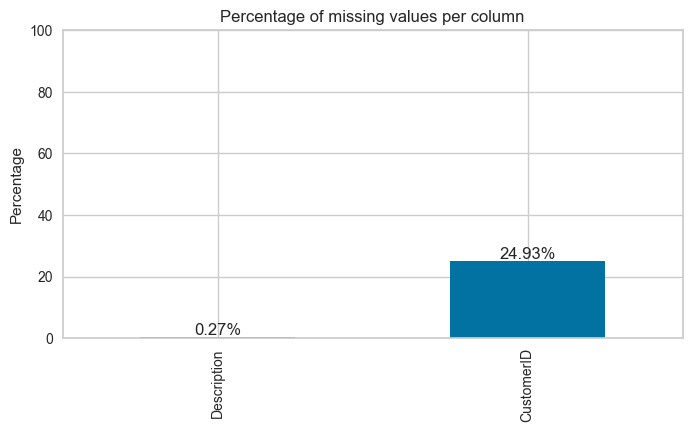

In [11]:
#VISUALIZING THE MISSING VALUES
plt.figure(figsize=(8, 4))
missing_percentage.plot(kind='bar')
plt.title('Percentage of missing values per column')
plt.ylim(0, 100)
plt.ylabel('Percentage')

for i in range(missing_percentage.shape[0]):
    plt.text(i, missing_percentage[i], f'{missing_percentage[i]:.2f}%', ha='center', va='bottom')
plt.show()

`CustomerID` (24.93% Missing Values)
The CustomerID column is pivotal for our analysis, being the key to linking purchase patterns to individual customers for clustering and personalized recommendations. With a substantial 24.93% of CustomerID values missing, the potential impact on the analysis could be significant. Imputing this large proportion of missing identifiers could introduce a high degree of bias and inaccuracies, undermining the validity of our customer segmentation and predictive modeling efforts.

Chosen Approach:

**Exclusion of Incomplete Records:** Given the importance of CustomerID in our analysis and the high proportion of missing values, we have chosen to exclude records with missing CustomerIDs. This decision prioritizes the accuracy and integrity of our customer-level analysis, ensuring that subsequent models are built on reliable and complete data.

`Description` (0.27% Missing Values)
The Description field has a relatively minor incidence of missing data. Despite the low percentage, closer inspection reveals inconsistencies in the data — the same StockCode does not consistently correspond to the same Description, indicating potential data quality issues.

Chosen Approach:

**Removal of Records with Missing Descriptions:** In light of the inconsistencies and the negligible proportion of missing Description data, we opt to remove these records. This maintains the overall quality and reliability of our dataset and ensures that our analysis is not compromised by underlying data entry errors.

In [12]:
#Removing the rows with missing values
df = df.dropna()

In [13]:
#check for misisng values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [14]:
#HANDLING DUPLICATES
#Checking for duplicates
df.duplicated().sum()

5225

In [15]:
duplicates = df[df.duplicated()]
duplicates

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


Duplicate Records Strategy

Due to the nature of our dataset, the presence of rows that are completely identical across all fields, including transaction times, is likely indicative of data entry errors rather than legitimate, repeated transactions. Such duplicates can skew our analysis by introducing noise and inaccuracies, especially when developing customer segmentation and product recommendation systems.

**Action Plan:**

To ensure the integrity of our analysis and the accuracy of our models, we will remove these duplicate rows from our dataset. This step is crucial for:

- **Enhancing Data Quality**: Ensuring that our dataset reflects unique transactions, thereby providing a more accurate view of customer behavior.
- **Improving Model Accuracy**: Cleaner data leads to more reliable clustering and predictions, essential for our goal of personalized customer engagement and effective product recommendations.

By purifying our dataset of these duplicates, we pave the way for more precise insights and actionable strategies.

In [16]:
#removing the duplicates
df = df.drop_duplicates()

In [17]:
df.shape

(401604, 8)

In [18]:
#EDA OF THE CATEGORICAL VARIABLES: InvoiceNo, StockCode, Description, Country

In [19]:
#InvoiceNo
df['InvoiceNo'].value_counts()

576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
C560912      1
560913       1
560917       1
572879       1
553049       1
Name: InvoiceNo, Length: 22190, dtype: int64

In [20]:
#let's check fo the cancelled orders 
cancelled_orders = df[df['InvoiceNo'].str.contains('C', na=False)]
cancelled_orders

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [ ]:
regular_transactions = df[~df['InvoiceNo'].str.contains('C', na=False)]

#calculating the percentage of cancelled orders
cancelled_percentage = (cancelled_orders.shape[0] / df.shape[0]) * 100
cancelled_percentage

2.209141343213713

In [ ]:
#change the type of the InvoiceNo to string
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

In [ ]:
#creation of a new column to indicate the cancelled orders
df['Cancelled']= df['InvoiceNo'].apply(lambda x: 1 if 'C' in x else 0)
df['Cancelled'].value_counts()

0    392732
1      8872
Name: Cancelled, dtype: int64

In [ ]:
#analysis of the rows where cancelled = 1
cancelled_orders = df[df['Cancelled'] == 1]
cancelled_orders.describe().drop('CustomerID', axis=1) #axis = 1 to drop the column

,Quantity,UnitPrice,Cancelled
count,8872.000000,8872.000000,8872.0
mean,-30.774910,18.899512,1.0
std,1172.249902,445.190864,0.0
min,-80995.000000,0.010000,1.0
25%,-6.000000,1.450000,1.0
50%,-2.000000,2.950000,1.0
75%,-1.000000,4.950000,1.0
max,-1.000000,38970.000000,1.0


**Quantity Analysis:**
- The Quantity column for cancellations has a large standard deviation, indicating a wide spread of the quantity of items involved in cancellations.
- The minimum value of -80,995 stands out as an extreme outlier, suggesting a very large bulk order was cancelled.
- The interquartile range (from the 25th percentile to the 75th percentile) suggests that most cancellations involve returning between 1 to 6 items.

**UnitPrice Analysis:**
- The standard deviation for UnitPrice is quite large, indicating significant variability in the prices of items involved in cancellations.
- The maximum UnitPrice of 38,970 is an outlier, suggesting that at least one cancellation involved an item of exceptionally high value.
- The more typical range of UnitPrice for cancelled orders (from the 25th to the 75th percentile) is between 1.45 and 4.95, which might represent the more common items involved in cancellations.

In [ ]:
#StockCode
df['StockCode'].value_counts() #3684 unique stock codes

85123A    2065
22423     1894
85099B    1659
47566     1409
84879     1405
          ... 
90104        1
90135        1
90027D       1
90027A       1
84746        1
Name: StockCode, Length: 3684, dtype: int64

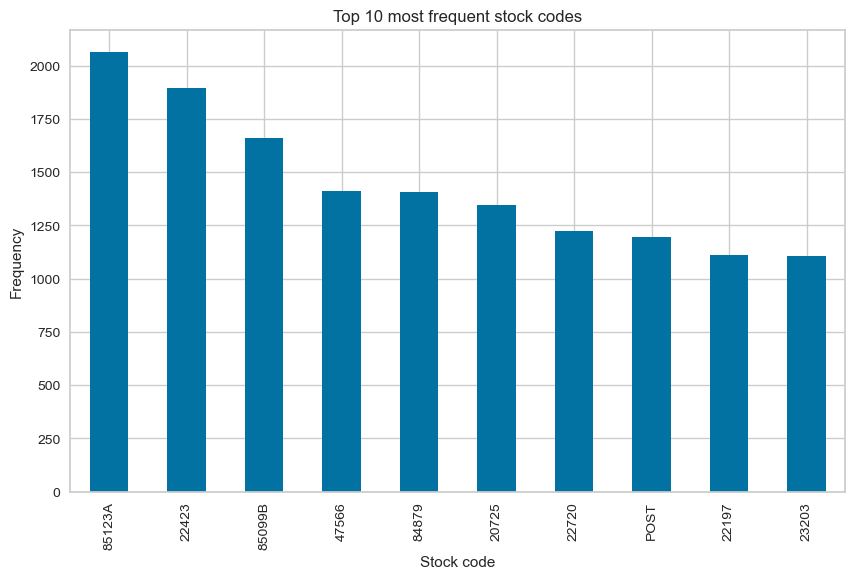

In [ ]:
#plot the top 10 most frequent stock codes
plt.figure(figsize=(10, 6))
df['StockCode'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 most frequent stock codes')
plt.xlabel('Stock code')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#We notice that the there is a code named POST, let's ceck for other codes that are not numeric
# Finding the number of numeric characters in each unique stock code
uni_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(uni_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

#printing the values counts for unique stok codes
print(numeric_char_counts_in_unique_codes)


5    3676
0       7
1       1
dtype: int64


In [ ]:
df['StockCode'] = df['StockCode'].astype(str)

# Identify non-numeric stock codes using a regular expression
non_numeric_codes = df[~df['StockCode'].str.match('^\d+$')]

# Display the unique non-numeric stock codes and their occurrences
print(non_numeric_codes['StockCode'].value_counts())

85123A    2065
85099B    1659
POST      1196
82494L     832
85099C     670
          ... 
84802B       1
84809B       1
90024C       1
90024F       1
90214Z       1
Name: StockCode, Length: 886, dtype: int64


In [ ]:
anomalous_stock_codes = [code for code in uni_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]
for code in anomalous_stock_codes:
    print(code)

POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [ ]:
#check post stock code rows
df[df['StockCode'] == 'POST'].head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.0,12583.0,France,0
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.0,12791.0,Netherlands,0
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.0,12662.0,Germany,0
5073,536840,POST,POSTAGE,1,2010-12-02 18:27:00,18.0,12738.0,Germany,0
5258,536852,POST,POSTAGE,1,2010-12-03 09:51:00,18.0,12686.0,France,0


In [ ]:
#check d stock code rows
df[df['StockCode'] == 'D'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom,1
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.0,United Kingdom,1
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340.0,United Kingdom,1
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422.0,United Kingdom,1


In [ ]:
df[df['StockCode'] == 'C2'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.0,14911.0,EIRE,0
12119,537368,C2,CARRIAGE,1,2010-12-06 12:40:00,50.0,14911.0,EIRE,0
12452,537378,C2,CARRIAGE,1,2010-12-06 13:06:00,50.0,14911.0,EIRE,0
19975,537963,C2,CARRIAGE,1,2010-12-09 11:30:00,50.0,13369.0,United Kingdom,0
20016,538002,C2,CARRIAGE,1,2010-12-09 11:48:00,50.0,14932.0,Channel Islands,0


In [ ]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100
percentage_anomalous

0.4768378801007958

Upon reviewing the dataset, we've identified special stock codes like 'POST' for postage costs, 'D' for discounts, and 'C2' for carriage charges. These entries, while important for full transactional records, do not represent physical product sales. They account for only 0.48% of the total transactions.

Rationale for Exclusion:

- Product-Centric Analysis: Our primary focus is on analyzing product sales data. Including service fees and discounts would not contribute to insights on product trends or customer purchasing behavior.
- Noise Reduction: Excluding these codes prevents the distortion of product-centric metrics and models, ensuring a more accurate representation of inventory and sales performance.
- Clarity in Financials: While crucial for financial reporting, these service-related codes are peripheral to analyses aimed at understanding product popularity or stock management.

Given their negligible proportion and potential to introduce noise into product-focused analyses, we have decided to remove these entries from the product transaction dataset. This strategic exclusion enhances the accuracy and relevance of our findings, concentrating our efforts on genuine product transactions.

In [ ]:
#Removing the rows with the anomalous stock codes
df = df[~df['StockCode'].isin(anomalous_stock_codes)]
df = pd.DataFrame(filter(lambda x: x['StockCode'] not in anomalous_stock_codes, df.to_dict('records')))
df.shape

(399689, 9)

In [ ]:
#Description
description_values = df['Description'].value_counts()
description_values

WHITE HANGING HEART T-LIGHT HOLDER    2058
REGENCY CAKESTAND 3 TIER              1894
JUMBO BAG RED RETROSPOT               1659
PARTY BUNTING                         1409
ASSORTED COLOUR BIRD ORNAMENT         1405
                                      ... 
FRYING PAN RED POLKADOT                  1
PEG BAG APPLE DESIGN                     1
PINK POLKADOT KIDS BAG                   1
BLACK DIAMOND CLUSTER NECKLACE           1
SET 12 COLOURING PENCILS DOILEY          1
Name: Description, Length: 3888, dtype: int64

<Axes: >

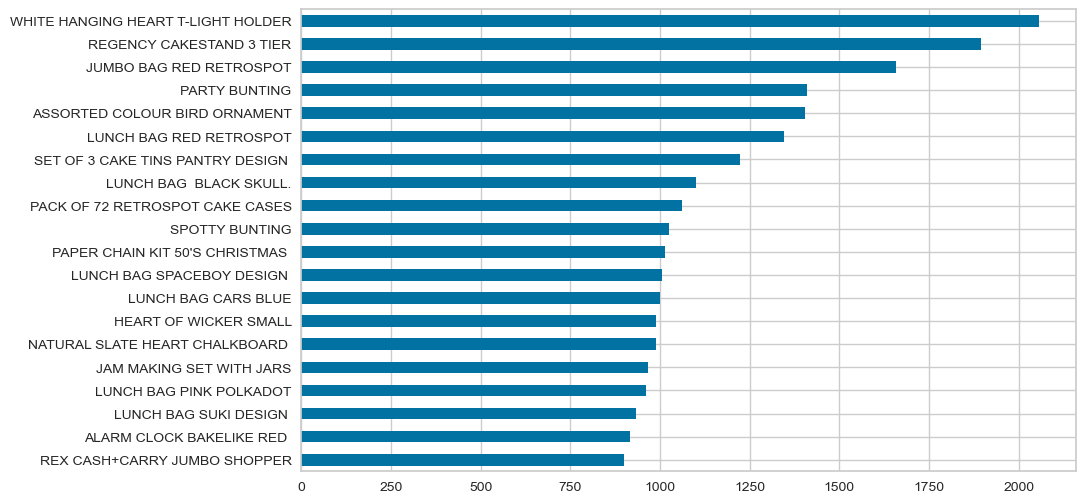

In [ ]:
#plot the top 15 most frequent descriptions orizontal bar plot ordered by frequency
plt.figure(figsize=(10,6))
description_values.head(20).sort_values(ascending=True).plot(kind='barh')

In [ ]:
#check if all the descriptions are in upper case
df['Description'].str.isupper().all()

False

In [ ]:
#get the non upper case descriptions
non_upper_case_descriptions = df[~df['Description'].str.isupper()]
non_upper_case_descriptions['Description'].value_counts()

BAG 125g SWIRLY MARBLES                252
3 TRADITIONAl BISCUIT CUTTERS  SET     207
BAG 250g SWIRLY MARBLES                201
POLYESTER FILLER PAD 40x40cm           185
POLYESTER FILLER PAD 45x45cm           135
BAG 500g SWIRLY MARBLES                115
Next Day Carriage                       80
FRENCH BLUE METAL DOOR SIGN No          75
POLYESTER FILLER PAD 45x30cm            37
POLYESTER FILLER PAD 30CMx30CM          26
ESSENTIAL BALM 3.5g TIN IN ENVELOPE     18
NUMBER TILE COTTAGE GARDEN No           12
FOLK ART GREETING CARD,pack/12          10
NUMBER TILE VINTAGE FONT No              7
THE KING GIFT BAG 25x24x12cm             7
POLYESTER FILLER PAD 65CMx65CM           5
FLOWERS HANDBAG blue and orange          3
High Resolution Image                    3
POLYESTER FILLER PAD 60x40cm             1
Name: Description, dtype: int64

In [ ]:
non_upper_case_descriptions[non_upper_case_descriptions['Description']== 'Next Day Carriage']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
144018,554835,23444,Next Day Carriage,1,2011-05-26 16:11:00,15.0,15241.0,United Kingdom,0
147145,555251,23444,Next Day Carriage,1,2011-06-01 15:12:00,15.0,13062.0,United Kingdom,0
147534,555312,23444,Next Day Carriage,1,2011-06-02 10:39:00,15.0,16484.0,United Kingdom,0
147881,555367,23444,Next Day Carriage,1,2011-06-02 14:28:00,15.0,17900.0,United Kingdom,0
153445,555948,23444,Next Day Carriage,1,2011-06-08 10:49:00,30.0,13752.0,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
389101,580622,23444,Next Day Carriage,1,2011-12-05 12:09:00,15.0,17006.0,United Kingdom,0
389114,580630,23444,Next Day Carriage,1,2011-12-05 12:11:00,15.0,12913.0,United Kingdom,0
395331,581132,23444,Next Day Carriage,1,2011-12-07 12:55:00,15.0,17590.0,United Kingdom,0
396617,581221,23444,Next Day Carriage,1,2011-12-08 09:40:00,15.0,17856.0,United Kingdom,0


In [ ]:
non_upper_case_descriptions[non_upper_case_descriptions['Description']== 'High Resolution Image']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
297478,571739,23702,High Resolution Image,1,2011-10-19 10:33:00,3.0,12500.0,Germany,0
341145,575910,23702,High Resolution Image,2,2011-11-11 16:05:00,1.5,14836.0,United Kingdom,0
349663,576659,23702,High Resolution Image,1,2011-11-16 11:09:00,21.0,15373.0,United Kingdom,0


In [ ]:
#let's calculate the percentage of non upper case descriptions
(non_upper_case_descriptions.shape[0]/df.shape[0])*100

0.34501825169068956

An inspection of the product descriptions has revealed the presence of lowercase entries which appear to be anomalies within our dataset. Notably, descriptions such as 'Next Day Carriage' and 'High Resolution Image' do not align with the standard product offerings of FarTrend and are likely to represent service fees or digital goods.

Proposed Strategy:
- Service charges like 'Next Day Carriage' and operational items such as 'High Resolution Image' do not correlate with physical products and therefore will be excluded. This ensures that our analysis focuses solely on tangible goods, which are the primary interest for our customer segmentation and recommendation system.

- Normalize the remaining product descriptions to uppercase. This standardization avoids the complication of case-sensitive duplicity and fosters uniformity, facilitating more accurate data analysis and model performance.

The execution of this strategy will refine our dataset, rendering it more amenable to the sophisticated analytical techniques we plan to employ. The end result will be a more precise and dependable basis for our machine learning endeavors, directly supporting the strategic goals of personalized marketing and improved customer experience at FarTrend


In [ ]:
#removing the 'Next Day Carriage' and 'High Resolution Image' rows
df = df[df['Description'] != 'Next Day Carriage']
df = df[df['Description']!= 'High Resolution Image']

#transforming th other rows in upper case
df['Description'] = df['Description'].str.upper()
df.shape

(399606, 9)

In [ ]:
#EDA OF THE NUMERICAL VARIABLES: UnitPrice, Quantity

In [ ]:
df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

The descriptive statistics for UnitPrice suggest that the average price of products is relatively low at around 2.90 units of currency, with half of the products priced at or below 1.95. However, there is notable variability in product prices, as indicated by a standard deviation of approximately 4.45, and a range that extends to a maximum of 649.50, which implies the presence of high-priced items in the catalogue that could significantly skew the average.


The presence of a minimum unit price of 0.00 warrants further investigation, as this could indicate instances of giveaways, data entry errors, or special promotions that effectively reduce the price to nothing. Understanding the nature of these zero-priced transactions is crucial, as they may need to be treated separately in the analysis to avoid distorting the overall pricing trends and the predictive modeling of customer behavior.


In [ ]:
#Let's check the description for the rows with the minimum unit price
df[df['UnitPrice']== 0].describe() [['Quantity', 'Cancelled']]

,Quantity,Cancelled
count,33.000000,33.0
mean,420.515152,0.0
std,2176.713608,0.0
min,1.000000,0.0
25%,2.000000,0.0
50%,11.000000,0.0
75%,36.000000,0.0
max,12540.000000,0.0


The transactions with a UnitPrice of 0 represent a very small subset of the data, and their exclusion is unlikely to significantly impact the dataset given the count of 33. The high standard deviation in Quantity suggests a wide variance in the volume of items involved in these zero-priced transactions. Since none of these transactions are marked as cancelled, they are not corrections or cancellations but actual transactions where goods were exchanged without monetary cost. Removing these entries will help to maintain the integrity of the dataset and the reliability of any statistical or machine learning models, which would assume a positive cost of goods sold in a standard e-commerce environment.

In [ ]:
#removing the rows with the unit price = 0
df = df[df['UnitPrice'] > 0]
df.shape

(399573, 9)

In [ ]:
#reset the index
df = df.reset_index(drop=True)

In [ ]:
#categorical variables
df.describe(include='object')

,InvoiceNo,StockCode,Description,Country
count,399573,399573,399573,399573
unique,21781,3674,3886,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,541,2065,2058,356008


The recent analysis shows that the number of unique stock codes and descriptions now closely aligns, reflecting significant progress in our data cleaning efforts. This crucial step ensures each product is accurately represented, setting the stage for more dependable analysis and modeling in our project.

OUTLIERS TREARTMENT

In our K-means clustering approach, we must be mindful of the impact of outliers, which are particularly influential in the positioning of centroids, potentially distorting the resulting clusters. Our preliminary analysis indicates a substantial portion of these outliers corresponds to cancellation orders. This is evident in the 'Quantity' data, where cancellations show a high variance, with extremes such as a cancelled bulk order of -80,995 items. Similarly, the 'UnitPrice' data reveals significant fluctuations, including an exceptional cancellation involving an item valued at 38,970.

Given the goal of understanding customer behavior through K-means clustering, addressing these outliers will be more effective after we transition from transactional data to a customer-centric view during feature engineering. This would allow us to evaluate the true behavioral patterns without prematurely discarding data that might be significant for segmenting customers—especially since cancellations, while outliers in transactional terms, could offer valuable insights into customer satisfaction and preferences. Thus, the treatment of outliers, particularly those linked with cancellations, will be deferred until we analyze the customer-based dataset, ensuring a robust foundation for our clustering strategy.

#### FEATURE ENGINEERING
- Total Spend per Transaction: Multiplying Quantity by UnitPrice to calculate the total spend for each line item, and then summing this up per invoice could provide insights into customer spending habits.
- Purchase Frequency: Counting the number of invoices per customer to understand how often they purchase.
- Average Spend per Visit: Calculating the average spend per invoice for each customer could help identify high-value customers.
- Product Variety per Transaction: Counting the number of unique StockCode or Description items per invoice to gauge the diversity of products a customer is interested in.
- Time Since Last Purchase: For each customer, calculating the time elapsed since their last purchase could help in identifying churn risk.
- Day of the Week and Hour of Purchase: Extracting day of the week and hour from InvoiceDate to understand peak shopping times and tailor marketing strategies accordingly.
- Cancellation Rate: Calculating the proportion of transactions that are cancellations (Cancelled == 1) for each customer to assess satisfaction or operational issues.
- Geographical Insights: Aggregating sales data by Country to identify key markets and tailor regional strategies.
- Seasonality Trends: Analyzing InvoiceDate to identify trends in purchasing behavior across different times of the year.

These features can provide a comprehensive view of customer engagement, preferences, and purchasing patterns, enabling targeted marketing efforts and improved customer segmentation. 

In [ ]:
#1 - Tot spending per customer
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

#grouping by customer id
total_spending_per_customer = df.groupby('CustomerID')['TotalSpend'].sum().reset_index().rename(columns={'TotalSpend': 'TotalCustomerSpend'})
total_spending_per_customer.head()

customer_df = pd.DataFrame(df['CustomerID'].unique(), columns=['CustomerID'])

# Merge the TotalCustomerSpend into customer_df
customer_df = customer_df.merge(total_spending_per_customer, on='CustomerID', how='left')

customer_df.head()

,CustomerID,TotalCustomerSpend
0,17850.0,5303.48
1,13047.0,3089.10
2,12583.0,6629.34
3,13748.0,948.25
4,15100.0,635.10
